Notebook for elaboration of grid frames and comparison of C results among optimizations. First we may want to import the libraries for data manipulation.

In [1]:
import os
import json
import pandas as pd
import math

# Imports for the implementation of the gif
import ffmpeg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

And define the C results paths.

In [2]:
BASE_RESULTS = './hpc/results/'

Let's now get the files inside the base folder and list them

In [3]:
files = os.listdir(BASE_RESULTS)
print(files)

['simulation_0_1.json', 'simulation_2_3.json', 'first vortex', '.gitkeep', 'simulation_3_3.json', 'simulation_1_2.json']


And remove the .gitkeep

In [4]:
for entry in files:
    if (entry == '.gitkeep'):
        files.remove(entry)

print(files)

['simulation_0_1.json', 'simulation_2_3.json', 'first vortex', 'simulation_3_3.json', 'simulation_1_2.json']


Amount of simulations that were performed:

In [5]:
len(files)

5

For the moment we're considering only the first simulation

In [6]:
sim = str(BASE_RESULTS+files[0])
file = json.load(open(sim))

print(sim)

meta = file['metadata']

./hpc/results/simulation_0_1.json


Metadata structure:

In [7]:
print(json.dumps(meta, indent=2))

{
  "time_step": 0.01,
  "ticks": 50,
  "world": {
    "width": 100,
    "height": 100,
    "width_bounds": 102,
    "height_bounds": 102
  },
  "fluid": {
    "viscosity": 0.0001,
    "density": 10,
    "diffusion": 0.0001
  }
}


Let's now get some info from the metadata

In [8]:
TICKS = meta['ticks']
FRAMES = TICKS+1
SQUARE_BOUNDS = meta['world']['width_bounds']
FRAME_POINTS = meta['world']['width_bounds']*meta['world']['height_bounds']

if (TICKS+1) != len(file['snapshots']):
    raise ValueError("Exception - the amount of snapshots is not equal to the amount of ticks +1 reported in the metadata")
if FRAME_POINTS != len(file['snapshots'][0]):
    raise ValueError("Exception - the amount of frames per snapshot is not equal to the one obtained from the metadata")

print("Ticks: ", TICKS)
print("Snapshots:", FRAMES)
print("Frame for each snapshot:", FRAME_POINTS)
print("Bounds with +2:", SQUARE_BOUNDS)

Ticks:  50
Snapshots: 51
Frame for each snapshot: 10404
Bounds with +2: 102


Now let's take a look at our snapshots in JSON format:

In [9]:
#print(json.dumps(file['snapshots'][2][4326:4336], indent=2))

Now let's extract our data and save it in a list of dataframes, where each dataframe will correspond to a snapshot at a certain time step of the simulation.

In [10]:
data = []
for i in range(FRAMES):
    data.append(pd.DataFrame(file["snapshots"][i]))

And check the structure of a single frame with x and y positions of the cell, d as density, u as force along the x dimension and v as force along the y.

In [11]:
data[0].head()

,x,y,d,u,v
0,0,0,0,0,0
1,1,0,0,0,0
2,2,0,0,0,0
3,3,0,0,0,0
4,4,0,0,0,0


Let's now normalize the data to be used in the graphic visualization phase.

In [12]:
plot_data = []

for i in range(len(data)):
    for idx, x in enumerate(data[i].d):
        
        tmp = np.int32(x*255)
        if tmp>=255:
            tmp = 255

        data[i].at[idx, 'd'] = tmp

for i in range(FRAMES):
    frame = {"x": data[i].x[:FRAME_POINTS], "y": data[i].y[:FRAME_POINTS], "density": data[i].d[:FRAME_POINTS]}
    plot_data.append(frame)

And now move to the gif generation.

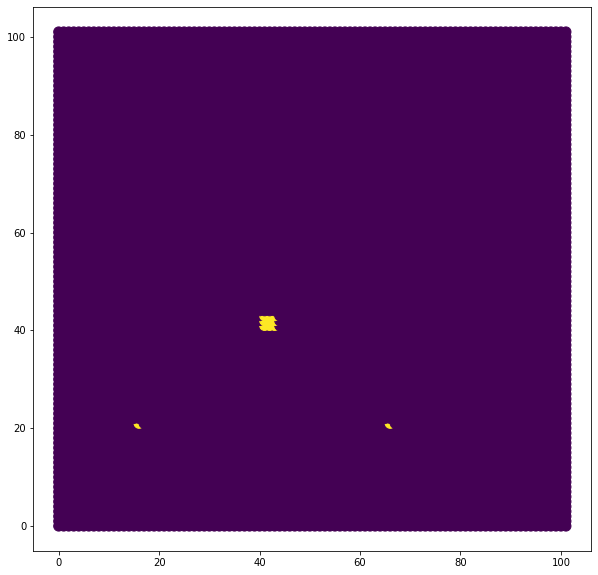

In [13]:
def main():
    #color_data = plot_data[0]['density']  
    color_data = np.random.random((FRAMES, FRAME_POINTS))  # THIS INSTEAD DOES SOMETHING SIMILAR
    x, y, c = plot_data[0]['x'], plot_data[0]['y'], plot_data[0]['density']

    fig = plt.figure(figsize=(10, 10))
    scat = plt.scatter(x, y, c=c, s=100)

    ani = animation.FuncAnimation(fig, update_plot, frames=range(FRAMES),
                                  fargs=(color_data, scat))
    plt.show()
    ani.save('animation.gif')

def update_plot(i, custom_data, scat):
    scat.set_offsets(np.c_[plot_data[i]['x'], plot_data[i]['y']])
    scat.set_array(plot_data[i]['density'])
    return scat,

main()